# Прогнозирование уровня средней заработной платы в России

Известны данные о заработной плате за каждый месяц с января 1993 по август 2016. Источник: http://sophist.hse.ru/exes/tables/WAG_M.htm

Необходимо проанализировать данные, подобрать для них оптимальную прогнозирующую модель в классе ARIMA и построить прогноз на каждый месяц на два года вперёд от конца данных.

Импортируем необходимые библиотеки

In [93]:
%pylab inline
import pandas as pd
from scipy import stats
import statsmodels.api as sm
import matplotlib.pyplot as plt
import warnings
from itertools import product

Populating the interactive namespace from numpy and matplotlib


C:\Users\kravchko\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\core\magics\pylab.py:160: UserWarning: pylab import has clobbered these variables: ['product']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


Определим функцию для обратного преобразования Бокса-Кокса

In [94]:
def invboxcox(y, lmbda):
    if lmbda == 0:
        return(np.exp(y))
    else:
        return(np.exp(np.log(lmbda*y+1)/lmbda))

## 1. Визуальный анализ ряда

Импорт данных

In [95]:
data = pd.read_csv("WAG_C_M.csv", sep=";",
                   index_col=["month"], parse_dates=["month"], dayfirst=True)
data.columns = ['salary']
data.head()

,salary
month,
1993-01-01,15.3
1993-02-01,19.1
1993-03-01,23.6
1993-04-01,30.6
1993-05-01,37.5


Построение графика для визуального анализа ряда

<Figure size 1080x360 with 0 Axes>

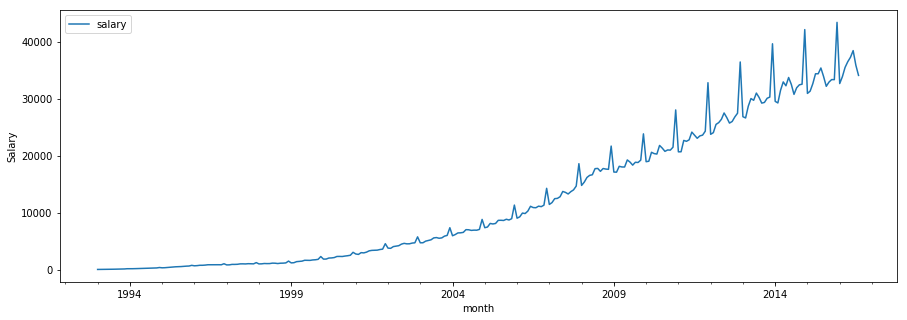

In [96]:
plt.figure(figsize(15, 5))
data.plot()
plt.ylabel('Salary')
pylab.show()

Проверка стационарности с помощью критерия Дики-Фуллера и STL-декомпозиция ряда

Критерий Дики-Фуллера: p=0.9918


<Figure size 1080x720 with 0 Axes>

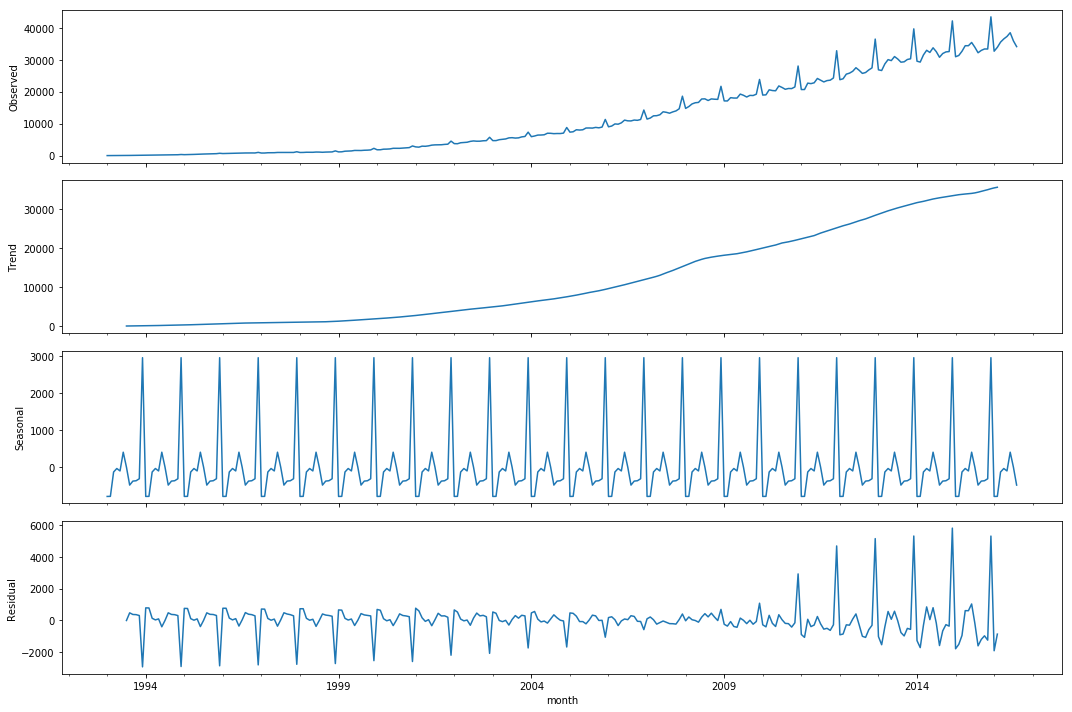

In [97]:
plt.figure(figsize(15, 10));
sm.tsa.seasonal_decompose(data.salary).plot();
print("Критерий Дики-Фуллера: p={:.4f}".format(
    sm.tsa.stattools.adfuller(data.salary)[1]))

Критерий Дики-Фуллера не отвергает гипотезу нестационарности.

## 2. Стабилизация дисперсии

Сделаем преобразование Бокса-Кокса для стабилизации дисперсии:

Оптимальный параметр преобразования Бокса-Кокса: 0.2632
Критерий Дики-Фуллера: p=0.6969


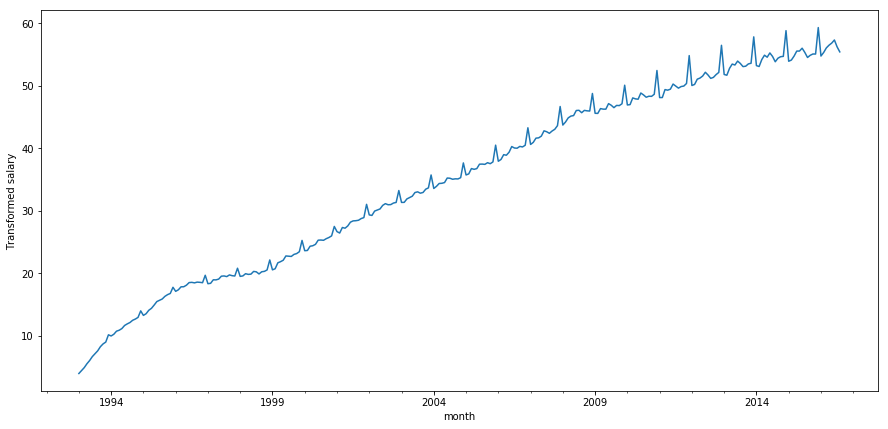

In [98]:
data['salary_box'], lmbda = stats.boxcox(data.salary)
plt.figure(figsize(15, 7))
data.salary_box.plot()
plt.ylabel(u'Transformed salary')
print("Оптимальный параметр преобразования Бокса-Кокса: {:.4f}".format(lmbda))
print("Критерий Дики-Фуллера: p={:.4f}".format(sm.tsa.stattools.adfuller(data.salary_box)[1]))

Критерий Дики-Фуллера не отвергает гипотезу нестационарности. В ряде отчетливо виден тренд и сезонность.

## 3. Выбор порядка дифференцирования

В ряде отчетливо виден тренд и сезонность.
Попробуем сезонное дифференцирование; сделаем на продифференцированном ряде STL-декомпозицию и проверим стационарность:

Критерий Дики-Фуллера: p=0.0147


<Figure size 1080x720 with 0 Axes>

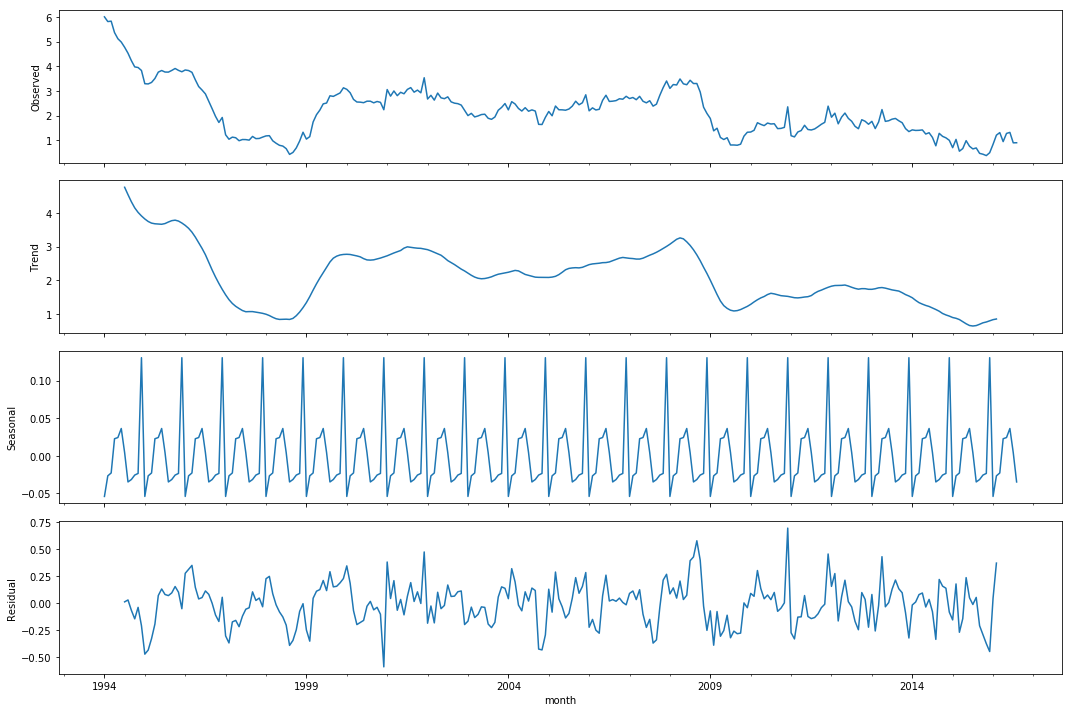

In [99]:
data['salary_box_diff'] = data.salary_box - data.salary_box.shift(12)
plt.figure(figsize(15, 10))
sm.tsa.seasonal_decompose(data.salary_box_diff[12:]).plot()
print(
    "Критерий Дики-Фуллера: p={:.4f}".format(
        sm.tsa.stattools.adfuller(data.salary_box_diff[12:])[1]))

Критерий Дики-Фуллера отвергает гипотезу нестационарности при уровне значимости $р < 0.05$

## 4. Выбор начальных приближений для $p, q, P,Q$

Посмотрим на ACF и PACF полученного ряда:

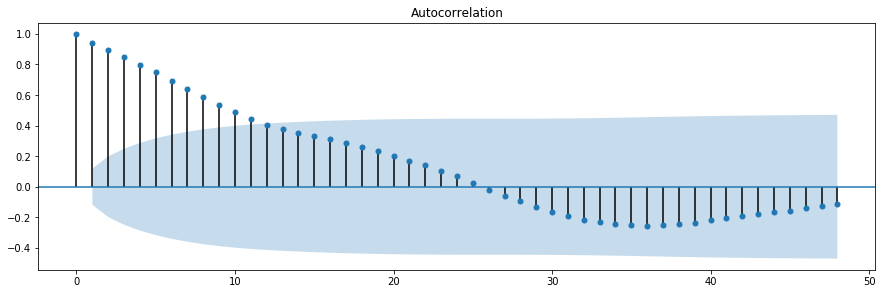

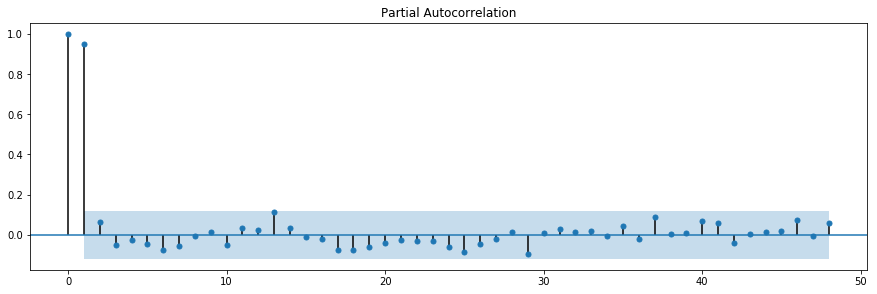

In [110]:
plt.figure(figsize(15, 10))

ax = plt.subplot(211)
sm.graphics.tsa.plot_acf(data.salary_box_diff[12:].values.squeeze(),
                         lags=48,
                         ax=ax)
pylab.show()

ax = plt.subplot(212)

sm.graphics.tsa.plot_pacf(data.salary_box_diff[12:].values.squeeze(),
                          lags=48,
                          ax=ax)

pylab.show()

**Начальные приближения:**
* Cезонных лагов со значимой корреляцией нет, значит, начальное приближение $Q=0$
* Параметр $q$ задаётся номером последнего несезонного лага, при котором автокорреляция значима. В данном случае можно взять начальное значение $q=11$

Значения параметров $p, P$ подбираются с использованием частичной автокорреляционной функции.
* Начальное приближение для параметра $P*S$ задаёт номер последнего сезонного лага, при котором частичная автокорреляция значима. Длина сезонного периода $S = 12$. Сезонных лагов со значимой корреляцией нет, значит начальное приближение
$P = 0$. 
* Аналогично, $p$ задаётся как номер последнего несезонного лага, при котором частичная автокорреляция значима. В данном случае можно взять начальное приближение $p = 1$.

In [111]:
ps = range(0, 2)
d = 1
qs = range(0, 12)
Ps = range(0, 1)
D = 1
Qs = range(0, 1)

In [112]:
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

24

## 5. Обучение и сравнение моделей-кандидатов, выбор победителя

In [113]:
%%time
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')

for param in parameters_list:
    # try except нужен, потому что на некоторых наборах параметров модель не обучается
    try:
        model = sm.tsa.statespace.SARIMAX(data.salary_box, order=(param[0], d, param[1]),
                                          seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    # выводим параметры, на которых модель не обучается и переходим к следующему набору
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    # сохраняем лучшую модель, aic, параметры
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

warnings.filterwarnings('default')

wrong parameters: (1, 2, 0, 0)
Wall time: 16.6 s


C:\Users\kravchko\AppData\Local\Continuum\anaconda3\lib\site-packages\IPython\utils\timing.py:67: DeprecationWarning: time.clock has been deprecated in Python 3.3 and will be removed from Python 3.8: use time.perf_counter or time.process_time instead
  return time.clock(),0.0


In [114]:
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by = 'aic', ascending=True).head())

       parameters        aic
21  (1, 10, 0, 0) -16.018471
22  (1, 11, 0, 0) -14.190893
9    (0, 9, 0, 0) -14.065244
16   (1, 5, 0, 0) -13.661218
10  (0, 10, 0, 0) -13.308459


Лучшая модель:

In [119]:
print(best_model.summary())

                                  Statespace Model Results                                 
Dep. Variable:                          salary_box   No. Observations:                  284
Model:             SARIMAX(1, 1, 10)x(0, 1, 0, 12)   Log Likelihood                  20.009
Date:                             Fri, 26 Oct 2018   AIC                            -16.018
Time:                                     12:01:00   BIC                             27.207
Sample:                                 01-01-1993   HQIC                             1.337
                                      - 08-01-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7662      0.171      4.469      0.000       0.430       1.102
ma.L1         -0.9983      

## 6. Анализ остатков построенной модели

Критерий Стьюдента: p=0.15604131433329294
Критерий Дики-Фуллера: p=2.945131507372862e-29


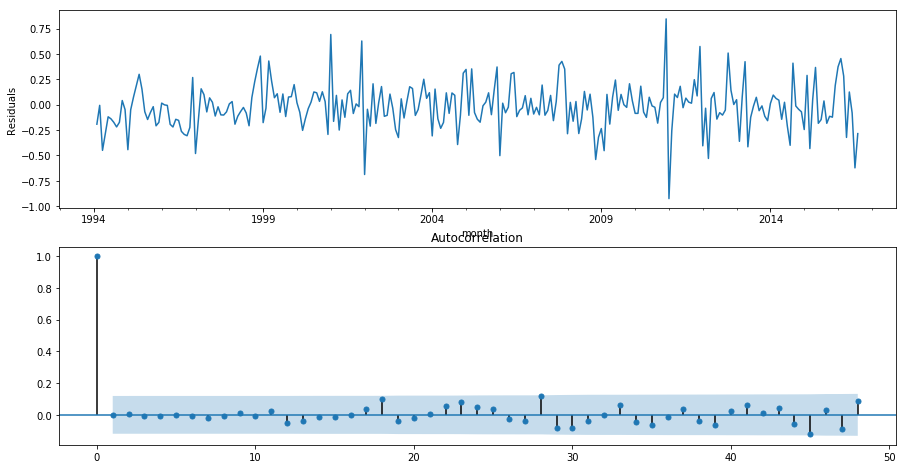

In [121]:
plt.figure(figsize(15, 8))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')

ax = plt.subplot(212)
sm.graphics.tsa.plot_acf(
    best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Критерий Стьюдента: p={}".format(
    stats.ttest_1samp(best_model.resid[13:], 0)[1]))

print("Критерий Дики-Фуллера: p={}".format(
    sm.tsa.stattools.adfuller(best_model.resid[13:])[1]))

Остатки несмещены (подтверждается критерием Стьюдента) стационарны (подтверждается критерием Дики-Фуллера и визуально), неавтокоррелированы (подтверждается критерием Льюнга-Бокса и коррелограммой). 

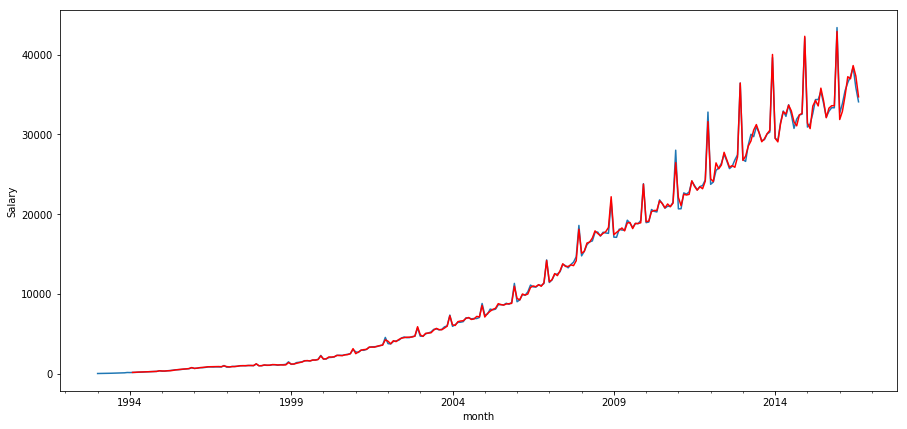

In [123]:
data['model'] = invboxcox(best_model.fittedvalues, lmbda)
plt.figure(figsize(15, 7))
data.salary.plot()
data.model[13:].plot(color='r')
plt.ylabel('Salary')
pylab.show()

## 7. Прогнозирование с помощью финальной модели

In [125]:
data.tail()

,salary,salary_box,salary_box_diff,salary_box_diff2,model
month,,,,,
2016-04-01,36497.0,56.526742,0.942729,-0.366210,37243.742472
2016-05-01,37270.0,56.860441,1.275065,0.332336,36978.693948
2016-06-01,38447.0,57.358885,1.316994,0.041929,38642.001291
2016-07-01,35888.0,56.260153,0.893671,-0.423323,37322.092893
2016-08-01,34095.0,55.455409,0.896620,0.002949,34722.388163


### Прогноз

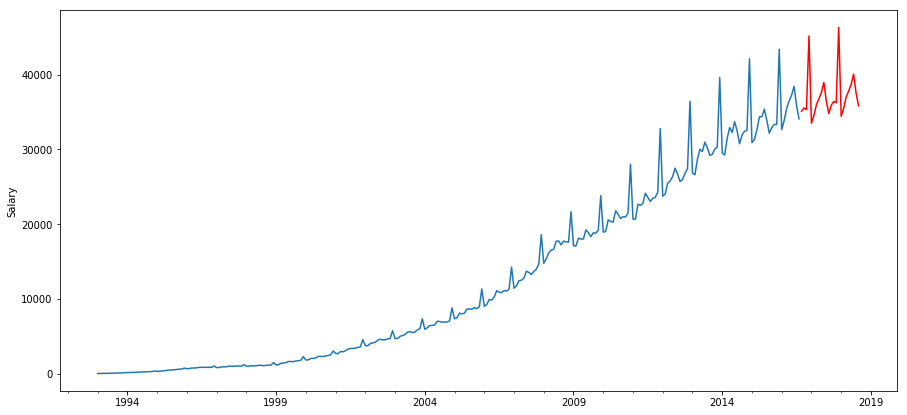

In [132]:
data2 = data[['salary']]

date_list = [datetime.datetime.strptime(
    "2016-09-01", "%Y-%m-%d") + relativedelta(months=x) for x in range(0, 24)]

future = pd.DataFrame(index=date_list, columns=data2.columns)

data2 = pd.concat([data2, future])

data2['forecast'] = invboxcox(best_model.predict(start=284, end=307), lmbda)

plt.figure(figsize(15, 7))
data2.salary.plot()
data2.forecast.plot(color='r')
plt.ylabel('Salary')
pylab.show()